# Semestrální práce: Detekce malarických buněk z datasetu Malaria

## Autor: Filip Janeba

## 1. Popis datasetu a cíl úlohy

Tato semestrální práce se zabývá klasifikací buněk na zdravé a parazitované pomocí datasetu Malaria. Dataset obsahuje 27 558 snímků buněk (barevné obrázky - 3 kanály, RGB), přičemž přibližně polovina je infikovaných a polovina zdravých. Cílem je vyzkoušet různé architektury neuronových sítí (MLP, CNN, transfer learning) a zhodnotit jejich výkonnost, včetně analýzy výsledků, ladění hyperparametrů a diskuse závěrů.

Úlohou je binární klasifikace, tedy za úkol je určit, zda je buňka zdravá nebo parazitovaná.

Odkaz na dataset: https://www.tensorflow.org/datasets/catalog/malaria

In [ ]:
pip install tensorflow tensorflow-datasets matplotlib seaborn scikit-learn

## 2. Import knihoven a nastavení prostředí

Vyvíjeno a testováno v Google Colab s GPU Tesla T4.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow verze:", tf.version)

TensorFlow verze: <module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>


## 3. Načtení datasetu a rozdělení na train/val/test

In [ ]:
(ds_full, ds_info) = tfds.load(
  'malaria',
  split='train',
  shuffle_files=True,
  with_info=True,
  as_supervised=True # => (image, label)
)

print(ds_info)
print("Počet vzorků (train split v TFDS):", ds_info.splits['train'].num_examples)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

### 3.1 Rozdělení na train/val/test

Dataset Malaria v TFDS je rozdělen pouze na train split proto si vytvoříme trénovací (70 %), validační (15 %) a testovací (15 %) množinu ručně. Při 27 558 vzorcích to odpovídá 19 290 pro trénink, 4 133 pro validaci a 4 133 pro test.

In [ ]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

ds_full = ds_full.shuffle(30000, reshuffle_each_iteration=False)

train_count = int(ds_info.splits['train'].num_examples * train_size)
val_count = int(ds_info.splits['train'].num_examples * val_size)
test_count = int(ds_info.splits['train'].num_examples * test_size)

ds_train = ds_full.take(train_count)
ds_rest = ds_full.skip(train_count)
ds_val = ds_rest.take(val_count)
ds_test = ds_rest.skip(val_count).take(test_count)

print("Počet trénovacích vzorků:", train_count)
print("Počet validačních vzorků:", val_count)
print("Počet testovacích vzorků:", test_count)

Počet trénovacích vzorků: 19290
Počet validačních vzorků: 4133
Počet testovacích vzorků: 4133


## 4. Předzpracování dat

Vytvoříme funkci pro základní normalizaci a změníme rozlišení obrázků na jednotnou velikost např. 64×64 pro zrychlení výpočtu.

In [ ]:
IMG_SIZE = (64, 64)
def preprocess(image, label):
  image = tf.image.resize(image, IMG_SIZE)
  image = tf.cast(image, tf.float32) / 255.0 # normalizace do [0,1]
  return image, label

In [ ]:
BATCH_SIZE = 32
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 5. Explorativní analýza

Zde lze provést rychlý náhled na několik obrázků z datasetu.

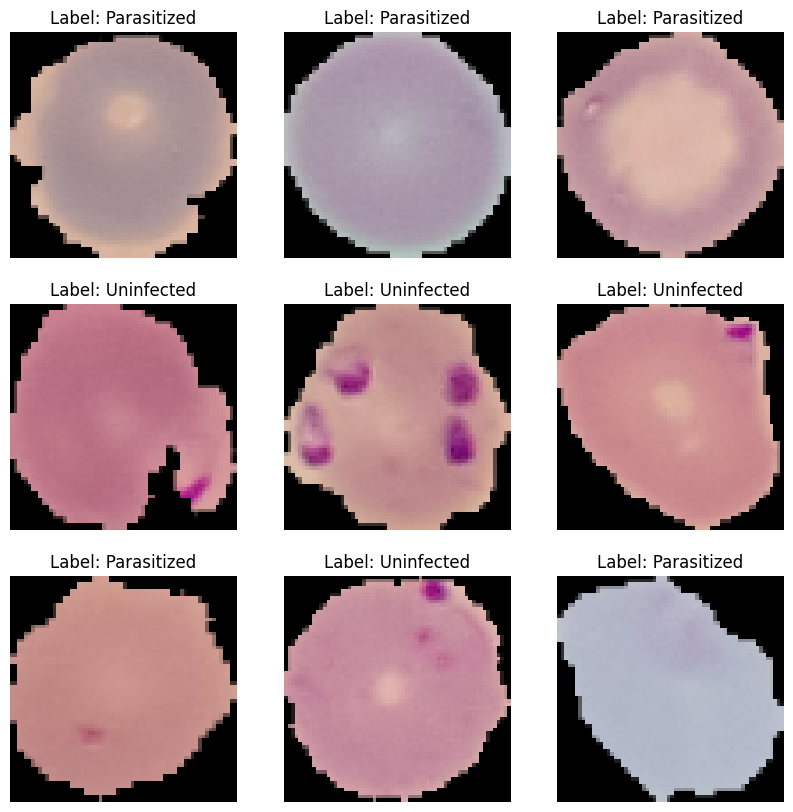

In [ ]:
import matplotlib.pyplot as plt
for images, labels in ds_train.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().squeeze())
        plt.title("Label: {}".format("Parasitized" if labels[i] == 1 else "Uninfected"))
        plt.axis("off")
    plt.show()

## 6. Modelování



Vytvoříme a vyzkoušíme **3** odlišné architektury:

1. **MLP**
2. **CNN**
3. **Transfer Learning (MobileNetV2)**


### 6.1 MLP

MLP architektura byla zvolena jako základní přístup k problému. Přestože není optimální pro zpracování obrazových dat, slouží jako důležitý výchozí bod pro porovnání s pokročilejšími architekturami. Pro MLP převedeme 2D obrázek na 1D vektor (Flatten) a použijeme husté vrstvy.

In [ ]:
mlp_model = keras.Sequential([
layers.Flatten(input_shape=(64, 64, 3)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

mlp_model.summary()

# Přidání callbacks pro lepší trénink
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,145,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,188,993 (12.17 MB)

 Trainable params: 3,188,097 (12.16 MB)

 Non-trainable params: 896 (3.50 KB)

Trénování MLP

In [ ]:
history = mlp_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 44s 38ms/step - accuracy: 0.6190 - loss: 0.6972 - val_accuracy: 0.6545 - val_loss: 0.6350
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.6729 - loss: 0.6143 - val_accuracy: 0.6729 - val_loss: 0.6463
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.6902 - loss: 0.5898 - val_accuracy: 0.6760 - val_loss: 0.5866
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 46s 38ms/step - accuracy: 0.6992 - loss: 0.5780 - val_accuracy: 0.7140 - val_loss: 0.5522
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.7060 - loss: 0.5683 - val_accuracy: 0.7213 - val_loss: 0.5526
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.6995 - loss: 0.5710 - val_accuracy: 0.7014 - val_loss: 0.5687
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.7088 - loss: 0.5625 - val_accuracy: 0.6051 - val_loss: 0.7263


### 6.2 CNN

Zde využijeme konvoluční vrstvy, pooling a dropout. CNN je pro obrazová data obvykle efektivnější.

In [ ]:
cnn_model = keras.Sequential([
layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Trénování CNN

In [ ]:
history_cnn = cnn_model.fit(
  ds_train,
  epochs=10,
  validation_data=ds_val
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.6369 - loss: 0.6301 - val_accuracy: 0.9110 - val_loss: 0.2484
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.9122 - loss: 0.2406 - val_accuracy: 0.9327 - val_loss: 0.1699
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.9388 - loss: 0.1776 - val_accuracy: 0.9509 - val_loss: 0.1619
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - accuracy: 0.9517 - loss: 0.1514 - val_accuracy: 0.9560 - val_loss: 0.1423
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.9493 - loss: 0.1484 - val_accuracy: 0.9664 - val_loss: 0.1113
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.9547 - loss: 0.1356 - val_accuracy: 0.9630 - val_loss: 0.1123
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9604 - loss: 0.1170 - val_accuracy: 0.9613 - val_loss: 0.1161
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - accuracy: 0.9615 - loss: 0.1096 - 

### 6.3 Transfer Learning (MobileNetV2)


Využijeme předtrénovaný model MobileNetV2, načteme jej bez vrchních (klasifikačních) vrstev a doplníme vlastní klasifikátor. Tento model byl předtrénován na rozsáhlém datasetu ImageNet.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(64,64,3),
  include_top=False,
  weights='imagenet')
base_model.trainable = False # Zamrazíme váhy base modelu

transfer_model = keras.Sequential([
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.3),
  layers.Dense(1, activation='sigmoid')
])

transfer_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

transfer_model.summary()

<ipython-input-15-aa93f3ce72bf>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(64,64,3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Trénování Transfer Learning modelu

In [ ]:
history_transfer = transfer_model.fit(
  ds_train,
  epochs=10,
  validation_data=ds_val
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 52s 48ms/step - accuracy: 0.8396 - loss: 0.3549 - val_accuracy: 0.9306 - val_loss: 0.1933
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 75s 42ms/step - accuracy: 0.9181 - loss: 0.2222 - val_accuracy: 0.9274 - val_loss: 0.1984
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.9224 - loss: 0.2036 - val_accuracy: 0.9335 - val_loss: 0.1894
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9252 - loss: 0.1992 - val_accuracy: 0.9337 - val_loss: 0.1835
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 37s 35ms/step - accuracy: 0.9268 - loss: 0.1949 - val_accuracy: 0.9383 - val_loss: 0.1764
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.9274 - loss: 0.2005 - val_accuracy: 0.9422 - val_loss: 0.1607
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.9238 - loss: 0.2017 - val_accuracy: 0.9378 - val_loss: 0.1707
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9290 - loss: 0.1931 - 

## 7. Ladění hyperparametrů

Pro optimalizaci výkonu jednotlivých modelů bylo provedeno systematické testování různých kombinací hyperparametrů. U každé architektury byly testovány specifické konfigurace s cílem najít optimální nastavení.

### 7.1 MLP

Pro vícevrstvý perceptron byly testovány různé velikosti skrytých vrstev a míry dropoutu.
*   (256, 128, 64, 0.3)
*   (512, 256, 128, 0.3)
*  (128, 64, 32, 0.3)
*  (256, 128, 64, 0.5)
*  (256, 128, 64, 0.4)

Nejlepší konfigurace dosáhla testovací přesnosti 71% s parametry:

*   První vrstva: 256 neuronů
*   Druhá vrstva: 128 neuronů
*   Třetí vrstva: 64 neuronů
*   Dropout: 0.4






### 7.2 CNN

U konvoluční neuronové sítě byly testovány různé počty filtrů, velikosti dense vrstvy a míry dropoutu.

*   (32, 64, 128, 0.3)
*   (64, 128, 256, 0.3)
*   (16, 32, 64, 0.3)
*   (32, 64, 128, 0.5)

Nejlepší konfigurace dosáhla testovací přesnosti 97% s parametry:

*   První konvoluční vrstva: 32 filtrů
*   Druhá konvoluční vrstva: 64 filtrů
*   Dense vrstva: 128 neuronů
*   Dropout: 0.3



### 7.3 Transfer Learnig (MobileNetV2)

U modelu využívajícího MobileNetV2 byl testován především vliv dropoutu.

*   0.3
*   0.4
*   0.5

Nejlepší konfigurace dosáhla testovací přesnosti 94% s dropout rate 0.3.


## 8. Evaluace modelů

### 8.1 Vyhodnocení na testovacích datech

In [ ]:
test_loss_mlp, test_acc_mlp = mlp_model.evaluate(ds_test)
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(ds_test)
test_loss_transfer, test_acc_transfer = transfer_model.evaluate(ds_test)

print("Test accuracy (MLP):", test_acc_mlp)
print("Test accuracy (CNN):", test_acc_cnn)
print("Test accuracy (Transfer Learning):", test_acc_transfer)

130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7116 - loss: 0.5548
130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9700 - loss: 0.0830
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.9411 - loss: 0.1670
Test accuracy (MLP): 0.7210258841514587
Test accuracy (CNN): 0.9719332456588745
Test accuracy (Transfer Learning): 0.9416888356208801


### 8.2 Matice záměn a klasifikační report

Vypočítáme předpovědi a matici záměn pro MLP model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

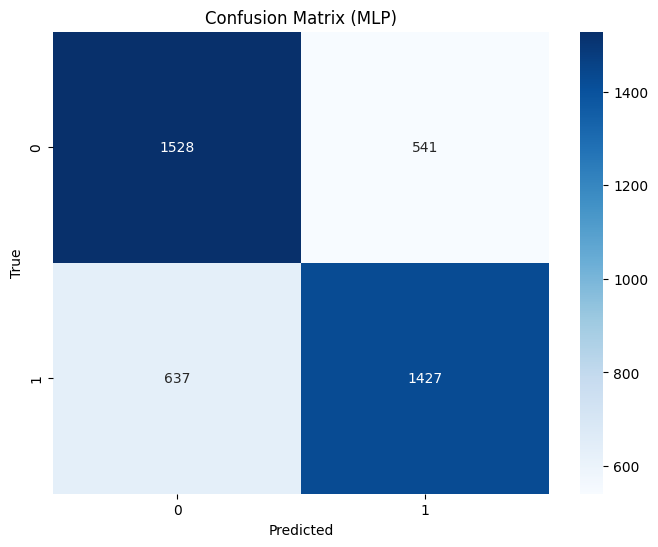

              precision    recall  f1-score   support

  Uninfected       0.71      0.74      0.72      2069
 Parasitized       0.73      0.69      0.71      2064

    accuracy                           0.71      4133
   macro avg       0.72      0.71      0.71      4133
weighted avg       0.72      0.71      0.71      4133



In [ ]:
y_true = []
y_pred = []

for images, labels in ds_test:
    predictions = mlp_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend([1 if p >= 0.5 else 0 for p in predictions])

# Vizualizace confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (MLP)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Výpis klasifikačního reportu
print(classification_report(y_true, y_pred, target_names=["Uninfected","Parasitized"]))

Vypočítáme předpovědi a matici záměn pro CNN model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

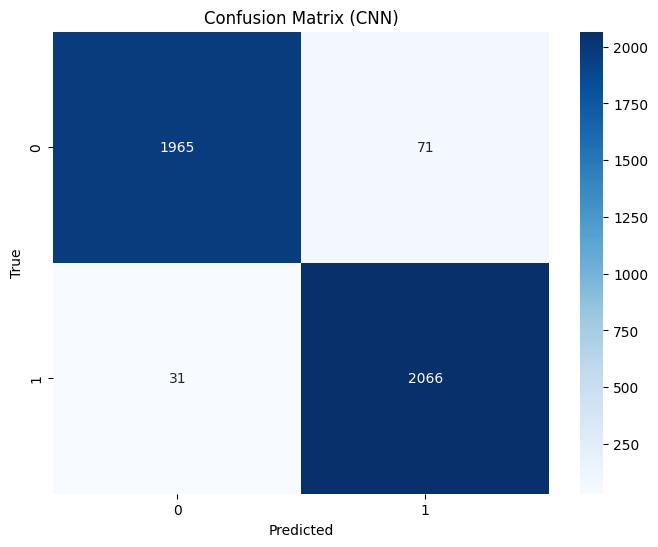

              precision    recall  f1-score   support

  Uninfected       0.98      0.97      0.97      2036
 Parasitized       0.97      0.99      0.98      2097

    accuracy                           0.98      4133
   macro avg       0.98      0.98      0.98      4133
weighted avg       0.98      0.98      0.98      4133



In [ ]:
y_true = []
y_pred = []

for images, labels in ds_test:
    predictions = cnn_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend([1 if p >= 0.5 else 0 for p in predictions])

# Vizualizace confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (CNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Výpis klasifikačního reportu
print(classification_report(y_true, y_pred, target_names=["Uninfected","Parasitized"]))

Vypočítáme předpovědi a matici záměn pro Transfer Learning (MobileNetV2) model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

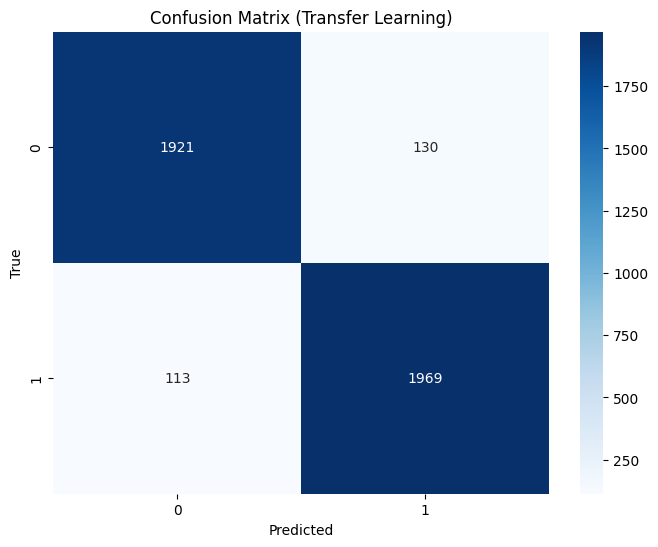

              precision    recall  f1-score   support

  Uninfected       0.94      0.94      0.94      2051
 Parasitized       0.94      0.95      0.94      2082

    accuracy                           0.94      4133
   macro avg       0.94      0.94      0.94      4133
weighted avg       0.94      0.94      0.94      4133



In [ ]:
y_true = []
y_pred = []

for images, labels in ds_test:
    predictions = transfer_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend([1 if p >= 0.5 else 0 for p in predictions])

# Vizualizace confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Transfer Learning)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Výpis klasifikačního reportu
print(classification_report(y_true, y_pred, target_names=["Uninfected","Parasitized"]))

## 9. Výsledky a shrnutí

V této úloze byly porovnány tři různé architektury neuronových sítí pro rozlišení buněk infikovaných malárií a zdravých buněk (MLP, CNN a Transfer Learning založený na MobileNetV2). Trénování probíhalo v prostředí Google Colab na grafické kartě T4. Časová náročnost pro 10 epoch u jednotlivých modelů byla přibližně:

*   **MLP**: 4 miuty
*   **CNN**: 6 minuty
*   **Transfer Learning (MobileNetV2)**: 7 minut


**Doporučení na zkrácení doby tréninku**
* Snížit počet epoch (např. z 10 na 5).
* Zmenšit dataset.
* Zmenšit rozlišení vstupního obrázku.

### 9.1 Shrnutí testovaných hyperparametrů a výsledků

MLP

*   Různé konfigurace s velikostmi 128–512 neuronů ve skrytých vrstvách a dropout 0.3–0.5.
*   Nejlepší kombinace (256/128/64 neuronů, dropout 0.4) dosáhla testovací přesnosti 71 %.
*   V klasifikačním reportu precision a recall kolem 70 %.





CNN


*  Testování různých počtů filtrů (16–64) a velikostí dense vrstvy (64–256) s dropout 0.3–0.5.
*   Nejlepší konfigurace (32 / 64 filtrů, dense 128, dropout 0.3) dosáhla testovací přesnosti 97 %, což je výrazné zlepšení oproti MLP.
*   Klasifikační report ukázal velmi vyrovnanou precision i recall kolem 97–98 %.



Transfer Learning (MobileNetV2)


*  Zkoušel se zejména různé drop-out (0.3, 0.4, 0.5).
*  Nejlepší výsledek s dropoutem 0.3 přinesl testovací přesnost 94 %.
*   Transfer Learning tedy poskytl velmi dobré výsledky, každopádně o něco nižší než konvoluční síť vytvořená od základu pro tuto úlohu.





### 9.2 Závěr

Nejlepších výsledků dosáhla konvoluční neuronová síť s přesností 97% na testovacích datech, následovaná transfer learning modelem s 94% přesností. Vícevrstvý perceptron dosáhl přesnosti 71%. Tyto výsledky ukazují výhody konvolučních architektur při zpracování obrazových dat oproti klasickým plně propojeným neuronovým sítím.

Pro praktické nasazení lze doporučit **CNN** model, který dosahuje nejvyšší přesnosti a poskytuje vyvážené výsledky pro obě třídy.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Final_Janeba_Filip-obraz.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Final_Janeba_Filip-obraz.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 634598 bytes to /content/drive/MyDrive/Colab Notebooks/Final_Janeba_Filip-obraz.html
